In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import random
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
data_dir = "../input/tomato-prime/tomato_small3" 


healthy_path = os.path.join(data_dir, 'healthy')
sick_path = os.path.join(data_dir, 'sick')  # Adjust this string if your folder has a different name for sick tomatoes

healthy_images = [os.path.join(healthy_path, fname) for fname in os.listdir(healthy_path)]
sick_images = [os.path.join(sick_path, fname) for fname in os.listdir(sick_path)]

print(f"Number of healthy images: {len(os.listdir(healthy_path))}")
print(f"Number of sick images: {len(os.listdir(sick_path))}")


Number of healthy images: 4182
Number of sick images: 4364


In [3]:
image_exts = ["jpeg", "jpg", "JPG", "JPEG", "png"]

In [4]:
for image_class in os.listdir(data_dir): 
    class_path = os.path.join(data_dir, image_class)
    
    if not os.path.isdir(class_path):  # Check if it's a directory
        continue

    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)


In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [6]:
# Keras auto-pre-process the images for you, and labels them for you as well, probably based on file structure! Call ?? to see exact details. 
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256))


Found 8546 files belonging to 2 classes.


In [7]:
#To view our images, because we are using a data-pipeline and not loading images into memory, we must first convert the images into a numpy iterator 
data_iterator = data.as_numpy_iterator()

In [8]:
# this is getting the batch for us
batch = data_iterator.next()

In [9]:
# Images represented as numpy arrays.This is confirming what we did with keras utils process above
batch[0].shape

(32, 256, 256, 3)

In [10]:
# This is the actual batch of data. Each number is an image and each  class 1 = sick & class 0 = healthy

batch[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1], dtype=int32)

In [11]:
unique, counts = np.unique(batch[1], return_counts=True)
print(dict(zip(unique, counts)))


{0: 12, 1: 20}


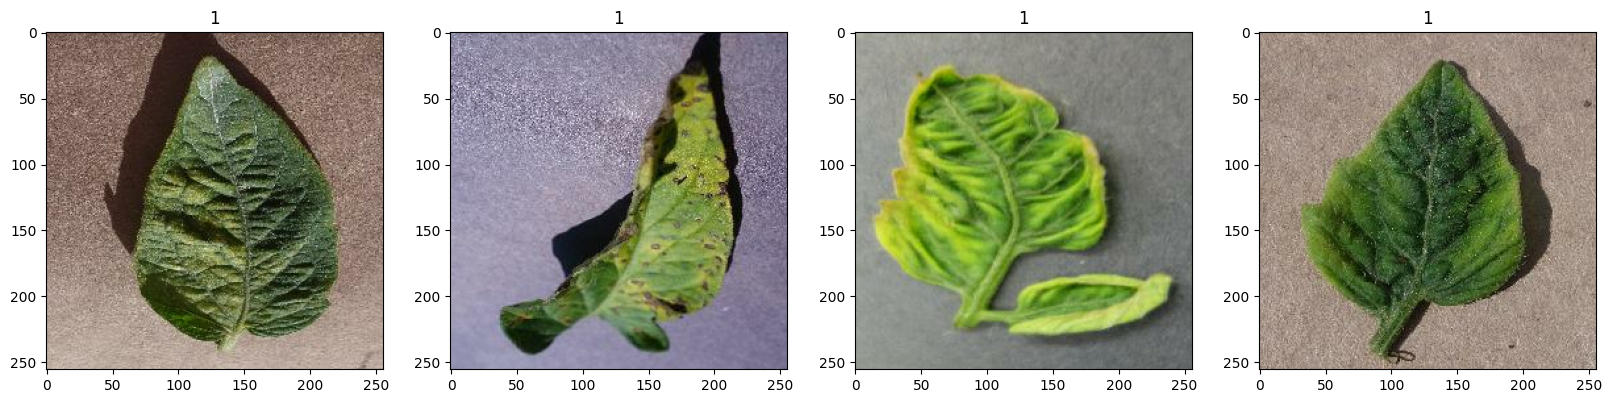

In [12]:
# plotting the images to **visually** double check which number (0 or 1) is sick or healthy
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

<h1>Pre-process data</h1>

In [13]:
# Normalizing pixel values is common when training neural networks. 
# Neural networks perform better when data lies is in a small range around 0.  
# Raw pixel values range from 0 to 255 which is not ideal for a neural network. 
# By dividing each pixel value by 255, you're rescaling the pixel values to be in the range [0, 1].

data = data.map(lambda x,y: (x/255, y))

In [14]:
scaled_iterator = data.as_numpy_iterator().next()

In [15]:
# images are now in a small range between 0 and 1 
scaled_iterator

(array([[[[0.3728554 , 0.6081495 , 0.27089462],
          [0.41485092, 0.6458865 , 0.3164747 ],
          [0.46887255, 0.69445467, 0.37064952],
          ...,
          [0.5696658 , 0.73437166, 0.41280302],
          [0.56460583, 0.7332333 , 0.41883376],
          [0.56078434, 0.7372549 , 0.41960785]],
 
         [[0.37561274, 0.6074142 , 0.2771446 ],
          [0.41737133, 0.64840686, 0.3189951 ],
          [0.46445072, 0.69003284, 0.3662277 ],
          ...,
          [0.5576799 , 0.7258784 , 0.4112951 ],
          [0.5678615 , 0.736489  , 0.42588225],
          [0.5677696 , 0.7372549 , 0.42659312]],
 
         [[0.37301192, 0.6043845 , 0.2749727 ],
          [0.43141323, 0.66228557, 0.3333635 ],
          [0.48360908, 0.7081969 , 0.38737458],
          ...,
          [0.586904  , 0.7671736 , 0.45142606],
          [0.6047794 , 0.7735701 , 0.4635924 ],
          [0.6073529 , 0.7721814 , 0.46427697]],
 
         ...,
 
         [[0.20082721, 0.6074755 , 0.27653188],
          [0.18866

<h1>Split Data</h1>

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

<h1>Deep model</h1>

<h3>3.1 Build deep learning model</h3>

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, load_model
from keras.models import Model, load_model
import tensorflow as tf


In [19]:
base_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(256,256,3)),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(units=256, activation='relu'),
    Dense(units=1, activation='sigmoid') 
])


In [20]:
f1_metric = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

base_model.compile(optimizer=optimizer, 
                   loss='binary_crossentropy', 
                   metrics=['accuracy', f1_metric])

In [21]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

<h3>3.2 train</h3>



In [22]:
logdir = "/Users/mirrosalim/Downloads/machine learning/data/logs"

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [24]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

In [25]:
hist = base_model.fit(train, epochs=50, validation_data=val, callbacks=[es])


Epoch 1/50
187/187 [==============================] - 44s 159ms/step - loss: 0.6352 - accuracy: 0.6255 - f1_score: 0.5938 - val_loss: 0.5393 - val_accuracy: 0.7252 - val_f1_score: 0.7720
Epoch 2/50
187/187 [==============================] - 36s 190ms/step - loss: 0.4870 - accuracy: 0.7704 - f1_score: 0.7739 - val_loss: 0.4366 - val_accuracy: 0.7942 - val_f1_score: 0.8215
Epoch 3/50
187/187 [==============================] - 37s 194ms/step - loss: 0.3813 - accuracy: 0.8446 - f1_score: 0.8439 - val_loss: 0.3185 - val_accuracy: 0.8779 - val_f1_score: 0.8840
Epoch 4/50
187/187 [==============================] - 36s 190ms/step - loss: 0.3199 - accuracy: 0.8718 - f1_score: 0.8721 - val_loss: 0.3311 - val_accuracy: 0.8614 - val_f1_score: 0.8774
Epoch 5/50
187/187 [==============================] - 37s 195ms/step - loss: 0.2733 - accuracy: 0.8909 - f1_score: 0.8924 - val_loss: 0.2405 - val_accuracy: 0.9027 - val_f1_score: 0.9086
Epoch 6/50
187/187 [==============================] - 38s 199ms/s

<h3>3.3 Plot performance</h3>

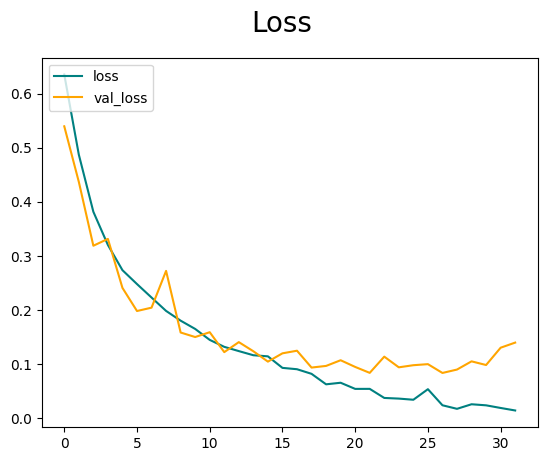

In [26]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

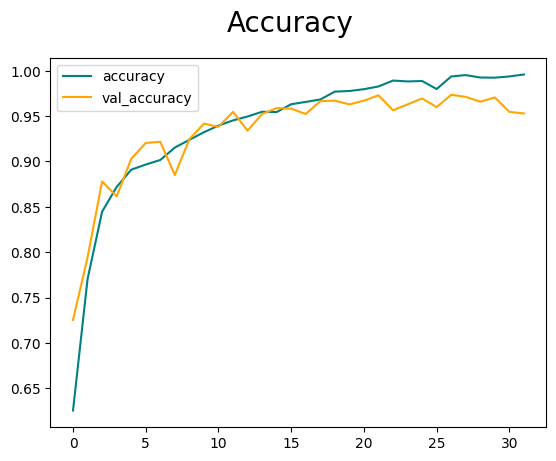

In [27]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

<h1>test model</h1>

In [28]:
#Evaluate the model on test data
test_loss, test_accuracy, test_f1_score = base_model.evaluate(test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 Score: {test_f1_score}")

26/26 [==============================] - 15s 50ms/step - loss: 0.1103 - accuracy: 0.9675 - f1_score: 0.9673
Test Loss: 0.11025676131248474
Test Accuracy: 0.9675480723381042
Test F1 Score: [0.96727276]


In [29]:
#evaluating the model on random scraped test data from google. Just to check models ability to generalize on uncommon data

# 1. Specify the path to the new scraped data
new_data_dir = "../input/prime-test/scarped_test_data_raw"

# 2. Load and label the data
scraped_test_data = tf.keras.utils.image_dataset_from_directory(new_data_dir)

# 3. Decrease pixel size to better train the network
new_pre_processed_data = scraped_test_data.map(lambda x,y: (x/255, y))

# 4. Evaluate the model on the new data
test_loss, test_accuracy, test_f1_score = base_model.evaluate(new_pre_processed_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 Score: {test_f1_score}")



Found 174 files belonging to 2 classes.
6/6 [==============================] - 3s 102ms/step - loss: 0.5856 - accuracy: 0.8678 - f1_score: 0.8867
Test Loss: 0.5855987668037415
Test Accuracy: 0.8678160905838013
Test F1 Score: [0.8866995]


<h1>Saving the model</h1>

In [30]:
base_model.save('lunarleaf.h5')